In [81]:
import numpy as np 
from functions import *
import structures as st
from sklearn.datasets import make_spd_matrix

import matplotlib.pyplot as plt

from skimage.restoration import denoise_tv_chambolle

from sklearn.datasets import fetch_olivetti_faces
import logging 
from numpy.random import RandomState
rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces

from noise_functions import add_spnoise, add_noise
dataset = []
noise_level = np.sqrt(0.001)
prob = 0.3
noisies = []
for img in faces_centered[0:370]:
    noisy = add_spnoise(img.reshape(64,64).copy(), noise_level, prob).reshape(64,64)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.reshape(64,64)
    im = (im - im.min())/(im.max() - im.min())
    dataset.append([img.reshape(64,64), noisy])
    noisies.append(noisy)

dataset_test = []
noisies_test = []
for img in faces_centered[370:400]:
    noisy = add_spnoise(img.reshape(64,64).copy(), noise_level, prob).reshape(64,64)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.reshape(64,64)
    im = (im - im.min())/(im.max() - im.min())
    dataset_test.append([img.reshape(64,64), noisy])
    noisies_test.append(noisy)

def f(alpha, V):
    total = 0
    N = len(V)
    for i in range(N):
        total += (1/(2*N)) * np.linalg.norm(div(V[i]) + dataset[i][1])
        total += alpha * TV(dataset[i][0])/N
    return total

def g(alpha):
    if alpha < 0:
        return np.inf  
    else:
        return 0

In [82]:
alpha0 = 20
V0 = []
for _ in dataset:
    V0.append(im_dual(_[1]))

In [83]:
iteration = 0 
max_iterations = 50
V = V0
Prev_V = [0 * v for v in V]
alpha = alpha0
N = len(V)
Lambda = 50
L = 10/N
eps = 1

alphas = []
re = []
initial_error = f(alpha, V)
errors = [initial_error]
prev_alpha = 10000 
diff = 1
theta_k = 0

while iteration < max_iterations and diff > 1e-4:
    Sigma = 0
    for i in range(N):
        Sigma += TV(dataset[i][0]) - TV(div(V[i]) + dataset[i][1])
    alpha_tilde_lhs = 1/(2 * Lambda) * (Lambda * alpha - Sigma/N)
    alpha_tilde = max(alpha_tilde_lhs, eps)
    V_tilde = []
    grad_v = 0 
    for i in range(N):
        init_v = im_dual(div(V[i]) + dataset[i][1])
        v_tilde = init_v
        for s in range(v_tilde.shape[1]):
            for t in range(v_tilde.shape[2]):
                vector = np.array([v_tilde[0, s, t], v_tilde[1, s, t]])
                norm = np.linalg.norm(vector, 2)
                if norm != 0:
                    if v_tilde[0, s, t] > alpha_tilde:
                        v_tilde[0, s, t] = (v_tilde[0,s,t]/norm) * alpha_tilde
                    else:
                        v_tilde[0, s, t] = 0
                        
                    if v_tilde[1, s, t] > alpha_tilde:
                        v_tilde[1, s, t] = (v_tilde[1,s,t]/norm) * alpha_tilde
                    else:
                        v_tilde[1, s, t] = 0
        V_tilde.append(v_tilde)
        grad_v += np.trace(init_v[0].T @ (V[i][0] - V_tilde[i][0]))
        grad_v += np.trace(init_v[1].T @ (V[i][1] - V_tilde[i][1]))
    grad_v = grad_v / N 
    
    grad_alpha = 0 
    for i in range(N):
        grad_alpha += TV(dataset[i][0])
    grad_alpha = grad_alpha / N 
    
    Df = 0 
    for i in range(N):
        Df += L * alpha * alpha_tilde 
    G = 0
    theta_k = min(1, (grad_v + grad_alpha + G)/(L * Df))
    for i in range(N):
        V[i] = V[i] + theta_k * (V_tilde[i] - V[i])
    alpha = alpha + theta_k * (alpha_tilde - alpha)
    
    error = f(alpha, V)
    if (iteration + 1) % 1 == 0:
        print(f'Iteration {iteration + 1}, Alpha/Tilde: {round(alpha, 2)} | {round(alpha_tilde, 2)}, Error: {round(error/N, 3)}, Theta: {round(theta_k, 3)}')
    errors.append(error/N)
    alphas.append(alpha)
    diff = abs(prev_alpha - alpha)
    prev_alpha = alpha
    iteration += 1 

Iteration 1, Alpha/Tilde: 15.46 | 15.46, Error: 9.175, Theta: 1
Iteration 2, Alpha/Tilde: 8.61 | 8.61, Error: 5.136, Theta: 1
Iteration 3, Alpha/Tilde: 5.19 | 5.19, Error: 3.117, Theta: 1
Iteration 4, Alpha/Tilde: 3.48 | 3.48, Error: 2.107, Theta: 1
Iteration 5, Alpha/Tilde: 2.63 | 2.63, Error: 1.602, Theta: 1
Iteration 6, Alpha/Tilde: 2.2 | 2.2, Error: 1.35, Theta: 1
Iteration 7, Alpha/Tilde: 1.98 | 1.98, Error: 1.223, Theta: 1
Iteration 8, Alpha/Tilde: 1.88 | 1.88, Error: 1.16, Theta: 1
Iteration 9, Alpha/Tilde: 1.82 | 1.82, Error: 1.129, Theta: 1
Iteration 10, Alpha/Tilde: 1.8 | 1.8, Error: 1.113, Theta: 1
Iteration 11, Alpha/Tilde: 1.78 | 1.78, Error: 1.105, Theta: 1
Iteration 12, Alpha/Tilde: 1.78 | 1.78, Error: 1.101, Theta: 1
Iteration 13, Alpha/Tilde: 1.77 | 1.77, Error: 1.099, Theta: 1
Iteration 14, Alpha/Tilde: 1.77 | 1.77, Error: 1.098, Theta: 1
Iteration 15, Alpha/Tilde: 1.77 | 1.77, Error: 1.098, Theta: 1
Iteration 16, Alpha/Tilde: 1.77 | 1.77, Error: 1.098, Theta: 1
Itera

In [86]:
errors_test = []
for alpha in alphas:
    rec_error = 0
    for i in range(len(dataset_test)):
        true = dataset_test[i][0]
        noisy = dataset_test[i][1]
        denoised = denoise_tv_chambolle(noisy, 1/alpha)
        rec_error += 0.5 * np.linalg.norm(denoised - true) ** 2
    errors_test.append(rec_error/len(dataset_test))

In [87]:
errors_test[-1]

14.588680240617638

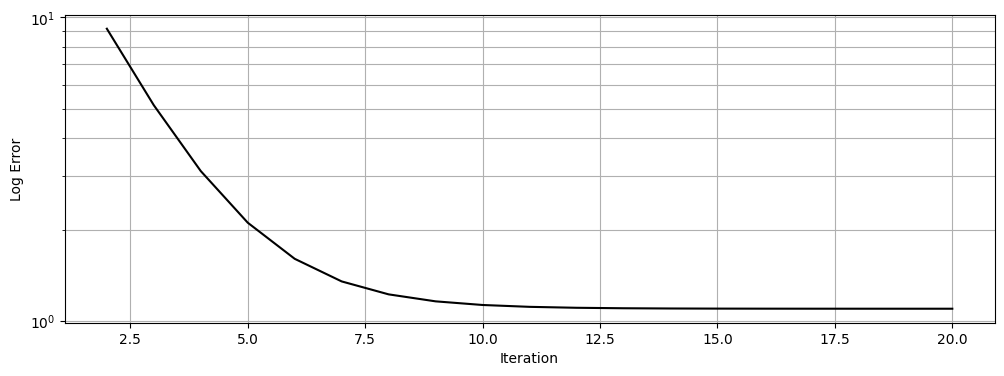

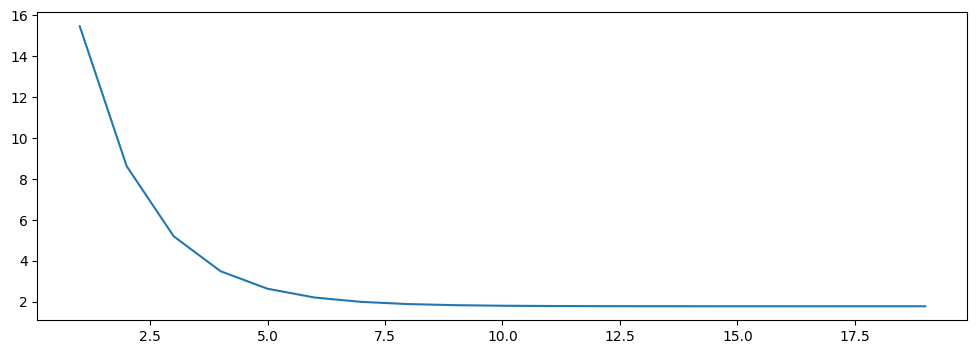

In [88]:
plt.figure(figsize = (12,4))
plt.plot([_ +1 for _ in range(1,iteration+1)], errors[1:], color = 'black')
plt.yscale('log')
plt.ylabel('Log Error')
plt.xlabel('Iteration')
plt.grid(True, which="both", ls="-")
plt.show()

'''
plt.figure(figsize = (12,4))
plt.plot([_ + 1 for _ in range(iteration)], re, label = 'Training Set Recovery Error')
plt.plot([_ + 1 for _ in range(iteration)], errors_test, label = 'Test Set Recovery Error')
plt.legend()
plt.show()
'''

plt.figure(figsize = (12,4))
plt.plot([_ + 1 for _ in range(iteration)], alphas)
plt.show()

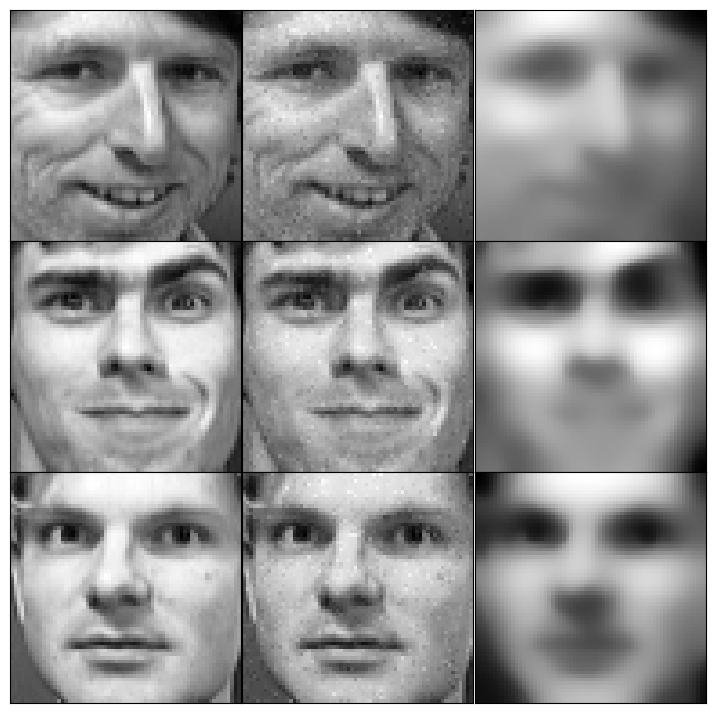

In [89]:
x = 10
y = 12
z = 29

fig, axes = plt.subplots(nrows = 3, ncols = 3,figsize=(18,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0, wspace=-0.75))
axes[0,0].imshow(dataset_test[x][0], cmap = 'grey')
axes[1,0].imshow(dataset_test[y][0], cmap = 'grey')
axes[2,0].imshow(dataset_test[z][0], cmap = 'grey')

axes[0,1].imshow(dataset_test[x][1], cmap = 'grey')
axes[1,1].imshow(dataset_test[y][1], cmap = 'grey')
axes[2,1].imshow(dataset_test[z][1], cmap = 'grey')

axes[0,2].imshow(denoise_tv_chambolle(dataset_test[x][1], 1/alpha), cmap = 'grey')
axes[1,2].imshow(denoise_tv_chambolle(dataset_test[y][1], 1/alpha), cmap = 'grey')
axes[2,2].imshow(denoise_tv_chambolle(dataset_test[z][1], 1/alpha), cmap = 'grey')